In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import scipy.stats as st
import scipy
from scipy.stats import chi2_contingency
from functions import plot_dendrogram
from sklearn import preprocessing
from sklearn import decomposition
from functions import *
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import ks_2samp

### Table of Contents

* [I.Nettoyage de données](#chapter1)
    * [1) Téléchargement des données](#section_1_1)
    * [2) Population en milliers d'habitants](#section_1_2)
        * [a. Population totale & suppression des doublon](#section_1_2_1)
        * [b. Croissance positive de la population ](#section_1_2_2)
    * [3) Disponibilité de protéines en g/personne/jour](#section_1_3)
        * [a. De protéines alimentaires](#section_1_3_1)
        * [b. De protéines animales](#section_1_3_2)
        * [c. Proportion de protéines animales](#section_1_3_3)
    * [4) Disponibilité alimentaire en calories par habitant](#section_1_4)
    * [5) Produit Intérieur Brut par habitant](#section_1_5)
    * [6) Échantillon de données](#section_1_6)
* [II. Classification hierarchique](#chapter2)
    * [1) Construction du dendogramme ](#section_2_1)
    * [2) Découpage en 5 clusters](#section_2_2)
    * [3) Boxplots comparatifs](#section_2_3)
        * [a. Croissance % 2013 - 2018](#section_2_3_1)
        * [b. Proportion protéines animales](#section_2_3_2)
        * [c. Total protéines g/p/j](#section_2_3_3)
        * [d. Protéines de Volailles g/p/j](#section_2_3_4)
        * [e. PIB par hab](#section_2_3_5)
        * [f. Choix du cluster](#section_2_3_6)
* [III. Réalisation de l'ACP ](#chapter3)
    * [1) Eboulis des valeurs propres](#section_3_1)
    * [2) Cercle des corrélations ](#section_3_2)
    * [3) Projections](#section_3_3)
        * [a. Des individus](#section_3_3_1)
        * [b. Des centroïdes ](#section_3_3_2)
* [IV. Tests](#chapter4)
    * [1) Tests d'adéquation](#section_4_1)
    * [2) Test de comparaison](#section_4_2)
        * [a. De la croissance](#section_4_2_1)
        * [b. Proportion protéines animales](#section_4_2_2)
        * [c. Total protéines g/p/j ](#section_4_2_3)
        * [d. PIB par hab](#section_4_2_4)
            

## I. Nettoyage de données <a class="anchor" id="section_1"></a>

### 1) Téléchargement des données <a class="anchor" id="section_1_1"></a>

In [2]:
dispo_anim = pd.read_csv("disponibilité alimentaire vivant.csv")
dispo_végé = pd.read_csv("disponibilité alimentaire cultures.csv")
population = pd.read_csv("populationp5.csv")
dispo_alim = pd.read_csv("dispo_alime.csv")
PIB = pd.read_csv("PIB.csv")

### 2) Population en milliers d'habitants  <a class="anchor" id="section_1_2"></a>

In [3]:
population.describe(include='all')

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
count,2226,2226,2226.000000,2226,2226.000000,2226,2226.0,2226,2226.000000,2226.000000,2226,2.226000e+03,2226,2226,485
unique,1,1,NaN,237,NaN,5,NaN,1,NaN,NaN,1,NaN,2,2,2
top,OA,Séries temporelles annuelles,NaN,Slovénie,NaN,Population totale,NaN,Population-Estimations,NaN,NaN,1000 personnes,NaN,X,Sources internationales sûres,"UNDESA, Population Division – World Urbanizati..."
freq,2226,2226,NaN,10,NaN,474,NaN,2226,NaN,NaN,2226,NaN,2206,2206,480
mean,NaN,NaN,134.070081,NaN,530.549865,NaN,3010.0,NaN,2015.500000,2015.500000,NaN,2.387872e+04,NaN,NaN,NaN
std,NaN,NaN,78.019638,NaN,22.013877,NaN,0.0,NaN,2.500562,2.500562,NaN,1.044481e+05,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,511.000000,NaN,3010.0,NaN,2013.000000,2013.000000,NaN,0.000000e+00,NaN,NaN,NaN
25%,NaN,NaN,68.000000,NaN,512.000000,NaN,3010.0,NaN,2013.000000,2013.000000,NaN,3.600557e+02,NaN,NaN,NaN
50%,NaN,NaN,132.000000,NaN,513.000000,NaN,3010.0,NaN,2015.500000,2015.500000,NaN,3.304709e+03,NaN,NaN,NaN
75%,NaN,NaN,198.000000,NaN,551.000000,NaN,3010.0,NaN,2018.000000,2018.000000,NaN,1.211856e+04,NaN,NaN,NaN


#### a. Population totale & suppression des doublons <a class="anchor" id="section_1_2_1"></a>

In [4]:
population = population.loc[population["Élément"].isin(['Population totale'])]
population = population.sort_values(by = "Valeur", ascending = True)
population = population.loc[~population["Code zone"].isin([351])]
population

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
1836,OA,Séries temporelles annuelles,94,Saint-Siège,511,Population totale,3010,Population-Estimations,2013,2013,1000 personnes,0.801,X,Sources internationales sûres,"UNDESA, Population Division – World Population..."
1839,OA,Séries temporelles annuelles,94,Saint-Siège,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,0.801,X,Sources internationales sûres,"UNDESA, Population Division – World Population..."
2084,OA,Séries temporelles annuelles,218,Tokélaou,511,Population totale,3010,Population-Estimations,2013,2013,1000 personnes,1.187,X,Sources internationales sûres,"UNDESA, Population Division – World Population..."
2087,OA,Séries temporelles annuelles,218,Tokélaou,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,1.319,X,Sources internationales sûres,"UNDESA, Population Division – World Population..."
1456,OA,Séries temporelles annuelles,160,Nioué,511,Population totale,3010,Population-Estimations,2013,2013,1000 personnes,1.612,X,Sources internationales sûres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,OA,Séries temporelles annuelles,231,États-Unis d'Amérique,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,327096.265,X,Sources internationales sûres,NaN
972,OA,Séries temporelles annuelles,100,Inde,511,Population totale,3010,Population-Estimations,2013,2013,1000 personnes,1280842.125,X,Sources internationales sûres,NaN
977,OA,Séries temporelles annuelles,100,Inde,511,Population totale,3010,Population-Estimations,2018,2018,1000 personnes,1352642.280,X,Sources internationales sûres,NaN
424,OA,Séries temporelles annuelles,41,"Chine, continentale",511,Population totale,3010,Population-Estimations,2013,2013,1000 personnes,1391883.330,X,Sources internationales sûres,NaN


#### b. Croissance positive de la population <a class="anchor" id="section_1_2_2"></a>

In [5]:
population = population.loc[:,['Code zone','Zone','Année','Valeur']]
population.rename(columns={'Valeur': 'Valeur*1000'}, inplace=True)
population = population.pivot_table(index=['Zone','Code zone'], columns=['Année'], values='Valeur*1000')
population['Croissance %'] = ((population[2018] - population[2013]) / population[2013]) * 100
population = population.reset_index()
population.rename(columns={'Code zone':'Code Pays'}, inplace=True)
population.rename(columns={'Zone':'Pays'}, inplace=True)
population = population.sort_values(by = "Croissance %", ascending = False)
population

Année,Pays,Code Pays,2013,2018,Croissance %
138,Oman,221,3764.806,4829.473,28.279465
112,Maldives,132,415.593,515.696,24.086787
76,Guinée équatoriale,61,1076.413,1308.975,21.605276
131,Niger,158,18504.281,22442.822,21.284485
139,Ouganda,226,35694.519,42729.036,19.707555
...,...,...,...,...,...
101,Lettonie,119,2044.957,1928.459,-5.696844
27,Bosnie-Herzégovine,80,3542.606,3323.925,-6.172885
106,Lituanie,126,3008.934,2801.264,-6.901780
151,Porto Rico,177,3503.858,3039.596,-13.250023


### 3) Disponibilité de protéines en g/personne/jour  <a class="anchor" id="section_1_3"></a>

In [6]:
dispo_alim.describe(include = 'all')

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
count,25974,25974,25974.000000,25974,25974.000000,25974,25974.000000,25974,25974.0,25974.0,25974,25974.00000,25974,25974
unique,1,1,NaN,175,NaN,2,NaN,97,NaN,NaN,2,NaN,1,1
top,FBSH,Bilans Alimentaire (Ancienne méthodologie et p...,NaN,Canada,NaN,Disponibilité alimentaire (Kcal/personne/jour),NaN,Viande d'Ovins/Caprins,NaN,NaN,Kcal/personne/jour,NaN,Fc,Donnée calculée
freq,25974,25974,NaN,172,NaN,14333,NaN,350,NaN,NaN,14333,NaN,25974,25974
mean,NaN,NaN,126.753369,NaN,668.481789,NaN,2642.465465,NaN,2013.0,2013.0,NaN,19.74275,NaN,NaN
std,NaN,NaN,74.928637,NaN,4.973169,NaN,94.885756,NaN,0.0,0.0,NaN,81.46090,NaN,NaN
min,NaN,NaN,1.000000,NaN,664.000000,NaN,2511.000000,NaN,2013.0,2013.0,NaN,-21.00000,NaN,NaN
25%,NaN,NaN,63.000000,NaN,664.000000,NaN,2560.000000,NaN,2013.0,2013.0,NaN,0.00000,NaN,NaN
50%,NaN,NaN,121.000000,NaN,664.000000,NaN,2618.000000,NaN,2013.0,2013.0,NaN,0.70000,NaN,NaN
75%,NaN,NaN,189.000000,NaN,674.000000,NaN,2736.000000,NaN,2013.0,2013.0,NaN,7.00000,NaN,NaN


#### a. De protéines alimentaires <a class="anchor" id="section_1_3_1"></a>

In [7]:
dispo_alim.rename(columns={'Code zone':'Code Pays'}, inplace=True)
dispo_alim.rename(columns={'Zone':'Pays'}, inplace=True)
dispo_alim = dispo_alim.loc[~dispo_alim["Code Pays"].isin([351])]

dispo_prot = dispo_alim.copy()
dispo_prot = dispo_prot [ (dispo_prot["Élément"] == "Disponibilité de protéines en quantité (g/personne/jour)")]
dispo_prot = dispo_prot.pivot_table(index=['Code Pays','Pays'], columns=['Produit'], values='Valeur')
dispo_prot = dispo_prot.reset_index()
dispo_prot ['Total prot alim'] = dispo_prot.iloc[:,1:100].sum(axis=1)
dispo_prot = dispo_prot.loc[ :, ['Code Pays','Pays','Total prot alim']]
dispo_prot = dispo_prot.sort_values(by = "Total prot alim", ascending = False)
dispo_prot

Produit,Code Pays,Pays,Total prot alim
66,99,Islande,133.06
63,96,Chine - RAS de Hong-Kong,129.07
72,105,Israël,128.00
90,126,Lituanie,124.36
95,132,Maldives,122.32
...,...,...,...
92,129,Madagascar,46.69
24,37,République centrafricaine,46.04
103,144,Mozambique,45.68
124,175,Guinée-Bissau,44.05


#### b. De protéines animales <a class="anchor" id="section_1_3_2"></a>

In [8]:
dispo_anim.describe(include="all")

,Code Domaine,Domaine,Code Pays,Pays,Code Élément,Élément,Code Produit,Produit,Code Année,Année,Unité,Valeur,Symbole,Description du Symbole
count,25569,25569,25569.000000,25569,25569.000000,25569,25569.000000,25569,25569.0,25569.0,25569,2.556900e+04,25569,25569
unique,1,1,NaN,175,NaN,6,NaN,28,NaN,NaN,4,NaN,3,3
top,CL,Disponibilité alimentaire - Elevage et pêche E...,NaN,Pérou,NaN,Disponibilité alimentaire en quantité (kg/pers...,NaN,Poissons Eau Douce,NaN,NaN,g/personne/jour,NaN,Fc,Donnée calculée
freq,25569,25569,NaN,161,NaN,4313,NaN,1050,NaN,NaN,12633,NaN,21256,21256
mean,NaN,NaN,126.553600,NaN,658.737377,NaN,2755.237006,NaN,2013.0,2013.0,NaN,7.210829e+04,NaN,NaN
std,NaN,NaN,74.793337,NaN,16.054949,NaN,24.964548,NaN,0.0,0.0,NaN,1.380850e+06,NaN,NaN
min,NaN,NaN,1.000000,NaN,641.000000,NaN,2731.000000,NaN,2013.0,2013.0,NaN,0.000000e+00,NaN,NaN
25%,NaN,NaN,63.000000,NaN,645.000000,NaN,2737.000000,NaN,2013.0,2013.0,NaN,2.000000e-02,NaN,NaN
50%,NaN,NaN,121.000000,NaN,646.000000,NaN,2745.000000,NaN,2013.0,2013.0,NaN,1.790000e+00,NaN,NaN
75%,NaN,NaN,189.000000,NaN,674.000000,NaN,2766.000000,NaN,2013.0,2013.0,NaN,1.918000e+01,NaN,NaN


In [9]:
dispo_anim = dispo_anim [ (dispo_anim["Élément"] == "Disponibilité de protéines en quantité (g/personne/jour)")]
dispo_anim = dispo_anim.pivot_table(index=['Code Pays','Pays'], columns=['Produit'], values='Valeur')
dispo_anim = dispo_anim.reset_index()
dispo_anim ['Total prot anim'] = dispo_anim.iloc[:,2:30].sum(axis=1)
dispo_anim = dispo_anim.loc[ :, ['Code Pays','Pays','Viande de Volailles','Total prot anim']]
dispo_anim = dispo_anim.loc[~dispo_anim["Code Pays"].isin([351])]
dispo_anim = dispo_anim.sort_values(by = "Total prot anim", ascending = False)
dispo_anim

Produit,Code Pays,Pays,Viande de Volailles,Total prot anim
66,99,Islande,10.88,122.75
63,96,Chine - RAS de Hong-Kong,19.58,102.52
107,150,Pays-Bas,9.90,102.01
90,126,Lituanie,9.27,100.70
45,67,Finlande,8.19,99.89
...,...,...,...,...
150,217,Togo,2.23,9.23
93,130,Malawi,0.46,8.43
89,123,Libéria,2.99,8.37
103,144,Mozambique,0.47,6.71


#### c. Proportion de protéines animales <a class="anchor" id="section_1_3_3"></a>

In [10]:
dispo_tot = pd.merge(dispo_anim, dispo_prot, on=['Pays','Code Pays'], how='right')
dispo_tot['Proportion prot'] = dispo_tot['Total prot anim'] / dispo_tot['Total prot alim'] 
dispo_tot = dispo_tot.sort_values(by = "Proportion prot", ascending = False)
dispo_tot

Produit,Code Pays,Pays,Viande de Volailles,Total prot anim,Total prot alim,Proportion prot
0,99,Islande,10.88,122.75,133.06,0.922516
2,150,Pays-Bas,9.90,102.01,111.46,0.915216
16,211,Suisse,6.66,83.45,92.89,0.898374
20,108,Kazakhstan,6.20,82.24,96.35,0.853555
4,67,Finlande,8.19,99.89,117.56,0.849694
...,...,...,...,...,...,...
166,159,Nigéria,0.54,10.42,63.77,0.163400
169,217,Togo,2.23,9.23,59.76,0.154451
172,144,Mozambique,0.47,6.71,45.68,0.146891
170,130,Malawi,0.46,8.43,64.53,0.130637


### 4) Disponibilité alimentaire en calories par habitant  <a class="anchor" id="section_1_4"></a>

In [11]:
dispo_cal = dispo_alim.copy()
dispo_cal = dispo_cal [ (dispo_cal["Élément"] == "Disponibilité alimentaire (Kcal/personne/jour)")]
dispo_cal = dispo_cal.pivot_table(index=['Code Pays','Pays'], columns=['Produit'], values='Valeur')
dispo_cal = dispo_cal.reset_index()
dispo_cal ['Total cal'] = dispo_cal.iloc[:,2:174].sum(axis=1)
dispo_cal = dispo_cal.loc[ :, ['Code Pays','Pays','Total cal']]
dispo_cal = dispo_cal.sort_values(by = "Total cal", ascending = False)
dispo_cal

Produit,Code Pays,Pays,Total cal
8,11,Autriche,3770.0
169,255,Belgique,3737.0
154,223,Turquie,3708.0
159,231,États-Unis d'Amérique,3682.0
72,105,Israël,3610.0
...,...,...,...
61,93,Haïti,2089.0
1,2,Afghanistan,2087.0
92,129,Madagascar,2056.0
168,251,Zambie,1924.0


### 5) Produit Intérieur Brut par habitant   <a class="anchor" id="section_1_5"></a>

In [12]:
PIB.describe(include='all')

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
count,4571,4571,4571.000000,4571,4571.0,4571,4571.0,4571,4571.000000,4571.000000,4571,4571.000000,4571,4571,0.0
unique,1,1,NaN,230,NaN,1,NaN,1,NaN,NaN,1,NaN,1,1,NaN
top,FS,Données de la sécurité alimentaire,NaN,Mali,NaN,Valeur,NaN,"PIB par habitant, ($ PPA internationaux consta...",NaN,NaN,I$,NaN,X,Sources internationales sûres,NaN
freq,4571,4571,NaN,20,NaN,4571,NaN,4571,NaN,NaN,4571,NaN,4571,4571,NaN
mean,NaN,NaN,1130.157515,NaN,6126.0,NaN,22013.0,NaN,2009.504485,2009.504485,NaN,17896.178429,NaN,NaN,NaN
std,NaN,NaN,2134.083630,NaN,0.0,NaN,0.0,NaN,5.753900,5.753900,NaN,19659.527710,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,6126.0,NaN,22013.0,NaN,2000.000000,2000.000000,NaN,630.700000,NaN,NaN,NaN
25%,NaN,NaN,83.000000,NaN,6126.0,NaN,22013.0,NaN,2005.000000,2005.000000,NaN,3852.300000,NaN,NaN,NaN
50%,NaN,NaN,156.000000,NaN,6126.0,NaN,22013.0,NaN,2010.000000,2010.000000,NaN,10881.200000,NaN,NaN,NaN
75%,NaN,NaN,234.000000,NaN,6126.0,NaN,22013.0,NaN,2014.000000,2014.000000,NaN,25231.950000,NaN,NaN,NaN


In [13]:
PIB = PIB [ (PIB["Année"] == 2013)]
PIB.rename(columns={'Code zone':'Code Pays'}, inplace=True)
PIB.rename(columns={'Valeur':'PIB par hab'}, inplace=True)
PIB.rename(columns={'Zone':'Pays'}, inplace=True)
PIB = PIB.loc[ :, ['Code Pays','Pays','PIB par hab']]
PIB = PIB.sort_values(by = "PIB par hab", ascending = False)
PIB = PIB.loc[~PIB["Code Pays"].isin([351])]
PIB

,Code Pays,Pays,PIB par hab
750,128,Chine - RAS de Macao,161939.0
1994,256,Luxembourg,106915.0
2787,179,Qatar,99133.7
3186,200,Singapour,85585.9
530,26,Brunéi Darussalam,66714.5
...,...,...,...
2409,158,Niger,1098.8
2074,130,Malawi,999.4
2867,250,République démocratique du Congo,972.5
590,29,Burundi,877.3


### 6) Échantillon de données   <a class="anchor" id="section_1_6"></a>

In [14]:
données = pd.merge(population, dispo_tot, on=['Pays','Code Pays'], how='right')
données = pd.merge(données, dispo_cal, on=['Pays','Code Pays'], how='left')
données = pd.merge(données, PIB, on=['Pays','Code Pays'], how='left')
données = données.loc[:,['Pays','Croissance %','Proportion prot','Total prot alim','Viande de Volailles','PIB par hab']]
données.rename(columns={'Croissance %':'Croissance % 2013 - 2018'}, inplace=True)
données.rename(columns={'Total prot alim':'Total protéines g/p/j'}, inplace=True)
données.rename(columns={'Total cal':'Total calories p/j'}, inplace=True)
données.rename(columns={'Proportion prot':'Proportion protéines animales'}, inplace=True)
données.rename(columns={'Viande de Volailles':'Protéines de Volailles g/p/j'}, inplace=True)
données = données.set_index('Pays')
données = données.sort_values(by = "Proportion protéines animales", ascending = True)
données

,Croissance % 2013 - 2018,Proportion protéines animales,Total protéines g/p/j,Protéines de Volailles g/p/j,PIB par hab
Pays,,,,,
Rwanda,13.785569,0.105652,56.79,0.45,1718.4
Malawi,14.545675,0.130637,64.53,0.46,999.4
Mozambique,15.395668,0.146891,45.68,0.47,1165.4
Togo,13.435059,0.154451,59.76,2.23,1360.6
Nigéria,14.035893,0.163400,63.77,0.54,5329.1
...,...,...,...,...,...
Finlande,1.536942,0.849694,117.56,8.19,45328.8
Kazakhstan,7.597158,0.853555,96.35,6.20,23720.8
Suisse,5.139219,0.898374,92.89,6.66,65251.2


In [15]:
échantillon = données.copy()
échantillon = échantillon[~échantillon['PIB par hab'].isnull()]
échantillon = échantillon[~échantillon['Protéines de Volailles g/p/j'].isnull()]
échantillon = échantillon[~échantillon['Total protéines g/p/j'].isnull()]
échantillon = échantillon[~échantillon['Croissance % 2013 - 2018'].isnull()]
échantillon

,Croissance % 2013 - 2018,Proportion protéines animales,Total protéines g/p/j,Protéines de Volailles g/p/j,PIB par hab
Pays,,,,,
Rwanda,13.785569,0.105652,56.79,0.45,1718.4
Malawi,14.545675,0.130637,64.53,0.46,999.4
Mozambique,15.395668,0.146891,45.68,0.47,1165.4
Togo,13.435059,0.154451,59.76,2.23,1360.6
Nigéria,14.035893,0.163400,63.77,0.54,5329.1
...,...,...,...,...,...
Finlande,1.536942,0.849694,117.56,8.19,45328.8
Kazakhstan,7.597158,0.853555,96.35,6.20,23720.8
Suisse,5.139219,0.898374,92.89,6.66,65251.2


On supprime également toutes les valeurs manquantes pour la construction des clusters

In [16]:
échantillon.describe(include='all')

,Croissance % 2013 - 2018,Proportion protéines animales,Total protéines g/p/j,Protéines de Volailles g/p/j,PIB par hab
count,166.000000,166.000000,166.000000,166.000000,166.000000
mean,6.969270,0.526646,81.352108,7.008916,19241.478313
std,6.194590,0.210627,20.175487,5.667472,21167.049250
min,-6.901780,0.105652,37.660000,0.140000,824.900000
25%,2.493727,0.324626,64.327500,1.902500,4220.625000
50%,6.132676,0.536860,81.250000,6.480000,11734.850000
75%,11.360202,0.700816,95.767500,10.470000,26467.500000
max,28.279465,0.922516,133.060000,25.780000,161939.000000


## II. Classification hierarchique<a class="anchor" id="section_2"></a>

### 1) Construction du dendogramme <a class="anchor" id="section_2_1"></a>

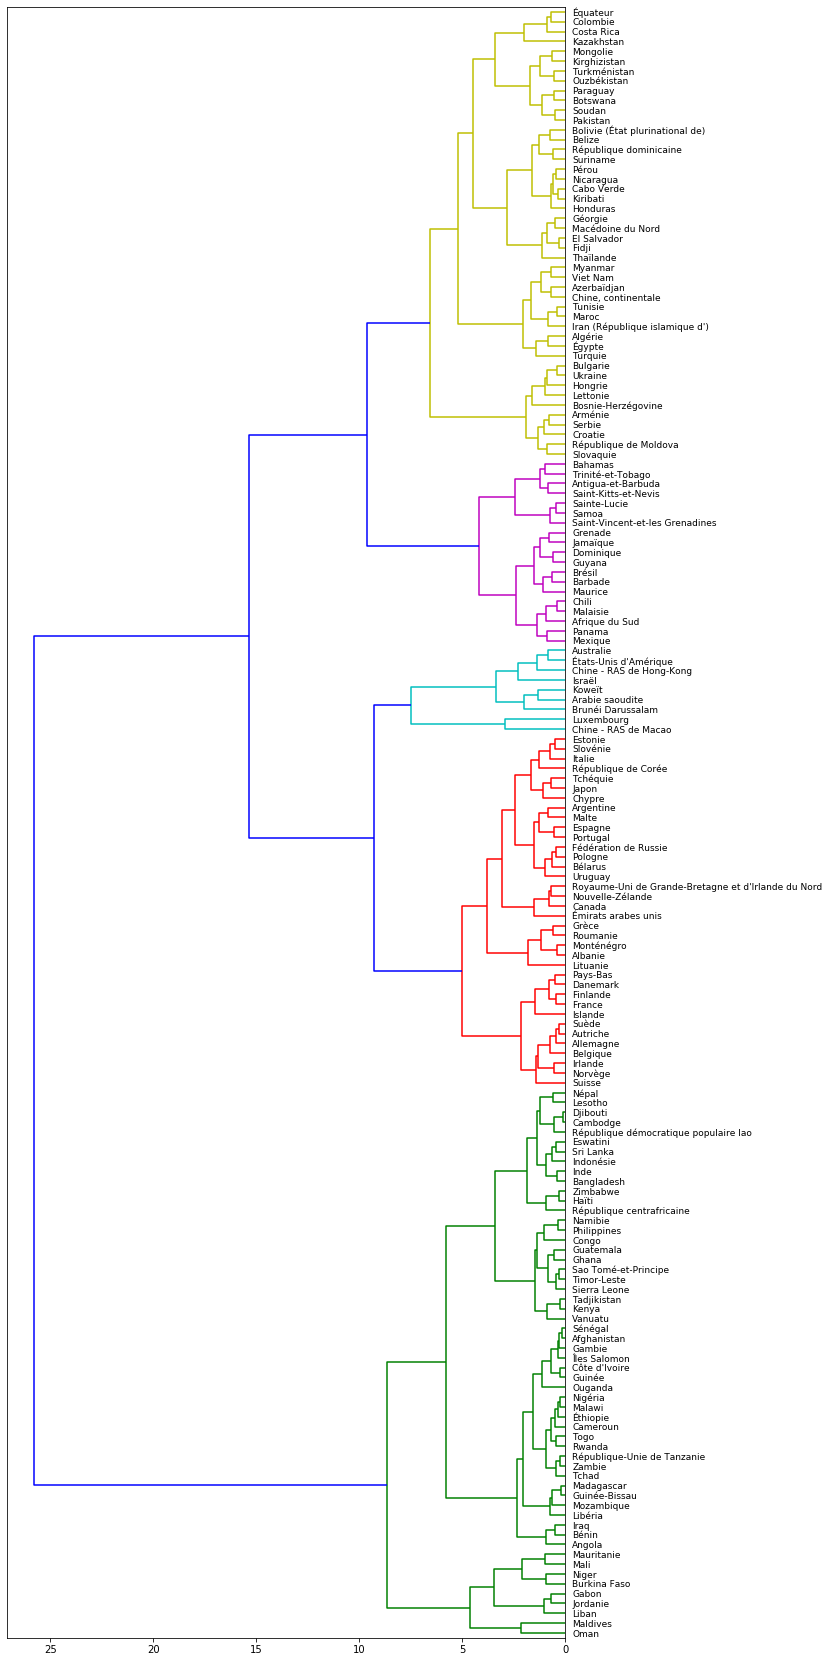

In [17]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage

# préparation des données pour le clustering
X = échantillon.values
names = échantillon.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme et classification en clusters à partir du seuil de 9
plt.figure(figsize=(10, 30))
D = dendrogram(Z=Z, labels=échantillon.index, color_threshold=9, orientation='left', leaf_font_size=9)

### 2) Découpage en 5 clusters <a class="anchor" id="section_2_2"></a>

In [18]:
clusters = fcluster(Z, 5, criterion='maxclust')
ward = échantillon.copy()
ward['cluster'] = clusters 
ward = ward.sort_values(by = "cluster", ascending = True)
ward.to_csv("pays.csv")
ward

,Croissance % 2013 - 2018,Proportion protéines animales,Total protéines g/p/j,Protéines de Volailles g/p/j,PIB par hab,cluster
Pays,,,,,,
Rwanda,13.785569,0.105652,56.79,0.45,1718.4,1
Cambodge,8.142107,0.294243,65.66,0.56,3191.9,1
Ouganda,19.707555,0.294833,52.64,0.51,1987.9,1
Indonésie,6.300596,0.295016,62.20,2.53,9457.0,1
Gambie,16.111426,0.297178,61.31,0.89,2131.4,1
...,...,...,...,...,...,...
Bolivie (État plurinational de),7.690533,0.511977,65.96,10.91,7444.5,5
Mongolie,10.008533,0.750866,80.80,1.03,10383.8,5
Cabo Verde,6.256790,0.509580,73.59,6.62,6323.3,5


### 3) Boxplots comparatifs <a class="anchor" id="section_2_3"></a>

#### a. Croissance % 2013 - 2018 <a class="anchor" id="section_2_3_1"></a>

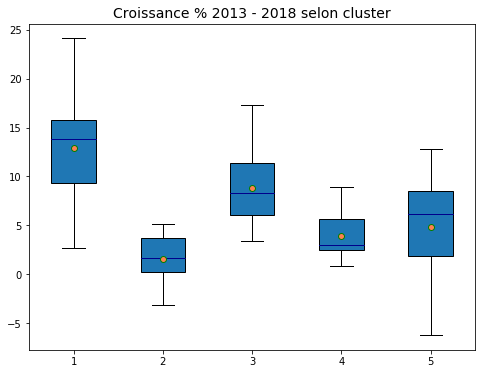

In [19]:
X = "cluster" # qualitative
Y = "Croissance % 2013 - 2018" # quantitative

modalites = ward[X].unique()
groupes = []
for m in modalites:
    groupes.append(ward[ward[X]==m][Y])


medianprops = {'color':"DarkBlue"}
meanprops = {'marker':'o', 'markeredgecolor':'Green',
            'markerfacecolor':'coral'}
plt.figure(figsize=(8, 6))
plt.title('Croissance % 2013 - 2018 selon cluster',fontsize=14) 
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Il serait préférable d'exporter du poulet dans les pays à forte croissance démographique.
Dans l'ordre croissant de préférence : cluster 2 - 4 - 5 - 3 - 1

In [20]:
X = "cluster" # qualitative
Y = "Croissance % 2013 - 2018" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(ward[X],ward[Y])

0.5346607276154751

#### b. Proportion protéines animales <a class="anchor" id="section_2_3_2"></a>

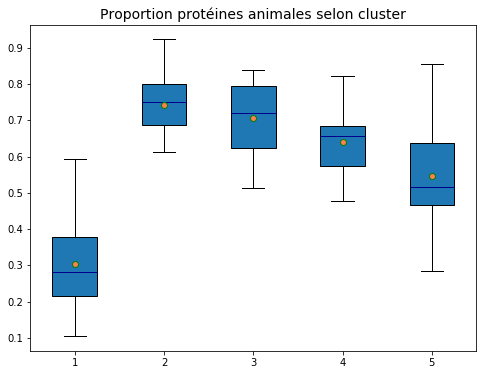

In [21]:
Y = "Proportion protéines animales" # quantitative

modalites = ward[X].unique()
groupes = []
for m in modalites:
    groupes.append(ward[ward[X]==m][Y])


medianprops = {'color':"DarkBlue"}
meanprops = {'marker':'o', 'markeredgecolor':'Green',
            'markerfacecolor':'coral'}
plt.figure(figsize=(8, 6))
plt.title('Proportion protéines animales selon cluster',fontsize=14) 
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Il serait préférable d'exporter du poulet dans les pays où la proportion de protéines animales est élevée.
Dans l'ordre croissant de préférence : cluster 1 - 5 - 4 - 3 - 2

In [22]:
X = "cluster" # qualitative
Y = "Proportion protéines animales" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(ward[X],ward[Y])

0.6785674203906701

#### c. Total protéines g/p/j <a class="anchor" id="section_2_3_3"></a>

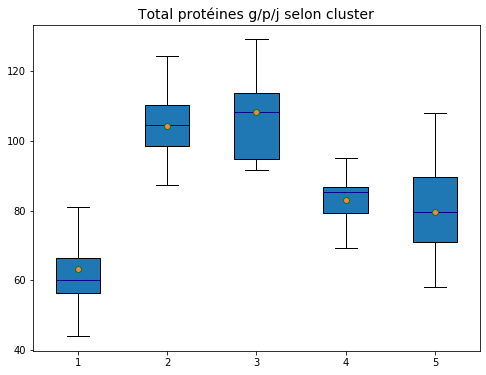

In [23]:
Y = "Total protéines g/p/j" # quantitative

modalites = ward[X].unique()
groupes = []
for m in modalites:
    groupes.append(ward[ward[X]==m][Y])


medianprops = {'color':"DarkBlue"}
meanprops = {'marker':'o', 'markeredgecolor':'Green',
            'markerfacecolor':'coral'}
plt.figure(figsize=(8, 6))
plt.title('Total protéines g/p/j selon cluster',fontsize=14) 
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Il serait préférable d'exporter du poulet dans les pays dont le total de protéines g/p/j est élevée.
Dans l'ordre croissant de préférence : cluster 1 - 5 - 4 - 2 - 3

In [24]:
X = "cluster" # qualitative
Y = "Total protéines g/p/j" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(ward[X],ward[Y])

0.6538348955629131

#### d. Protéines de Volailles g/p/j <a class="anchor" id="section_2_3_4"></a>

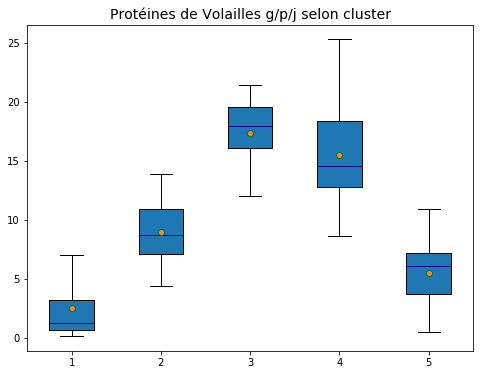

In [25]:
Y = "Protéines de Volailles g/p/j" # quantitative

modalites = ward[X].unique()
groupes = []
for m in modalites:
    groupes.append(ward[ward[X]==m][Y])


medianprops = {'color':"DarkBlue"}
meanprops = {'marker':'o', 'markeredgecolor':'Green',
            'markerfacecolor':'coral'}
plt.figure(figsize=(8, 6))
plt.title('Protéines de Volailles g/p/j selon cluster',fontsize=14) 
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Il serait préférable d'exporter du poulet dans les pays dont les protéines de Volailles g/p/j sont élevées.
Dans l'ordre croissant de préférence : cluster 1 - 5 - 2 - 4 - 3

In [26]:
X = "cluster" # qualitative
Y = "Protéines de Volailles g/p/j" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(ward[X],ward[Y])

0.700150578533057

#### e. PIB par hab <a class="anchor" id="section_2_3_5"></a>

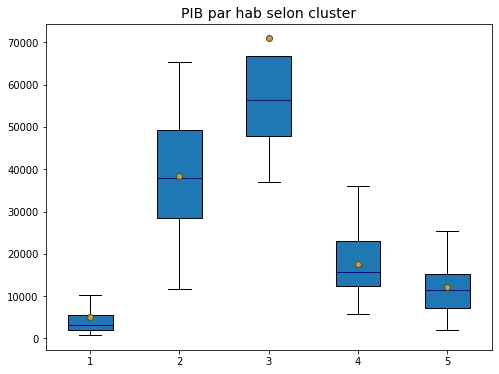

In [27]:
Y = "PIB par hab" # quantitative

modalites = ward[X].unique()
groupes = []
for m in modalites:
    groupes.append(ward[ward[X]==m][Y])


medianprops = {'color':"DarkBlue"}
meanprops = {'marker':'o', 'markeredgecolor':'Green',
            'markerfacecolor':'coral'}
plt.figure(figsize=(8, 6))
plt.title('PIB par hab selon cluster',fontsize=14) 
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Il serait préférable d'exporter du poulet dans les pays ou le PIB par hab est élevé.
Dans l'ordre croissant de préférence : cluster 1 - 5 - 4 - 2 - 3

In [28]:
X = "cluster" # qualitative
Y = "PIB par hab" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(ward[X],ward[Y])

0.6863191378821739

#### f. Choix du cluster <a class="anchor" id="section_2_3_6"></a>

Il serait préférable d'exporter du poulet dans les pays à forte croissance démographique.  
Dans l'ordre croissant de préférence : cluster 2 - 4 - 5 - 3 - 1  
Il serait préférable d'exporter du poulet dans les pays où la proportion de protéines animales est élevée.  
Dans l'ordre croissant de préférence : cluster 1 - 5 - 4 - 3 - 2  
Il serait préférable d'exporter du poulet dans les pays dont le total de protéines g/p/j est élevée.  
Dans l'ordre croissant de préférence : cluster 1 - 5 - 4 - 2 - 3  
Il serait préférable d'exporter du poulet dans les pays dont les protéines de Volailles g/p/j sont élevées.  
Dans l'ordre croissant de préférence : cluster 1 - 5 - 2 - 4 - 3  
Il serait préférable d'exporter du poulet dans les pays ou le PIB par hab est élevé.  
Dans l'ordre croissant de préférence : cluster 1 - 5 - 4 - 2 - 3  

Conclusion : Selon les critères et les variables séléctionnées, le cluster le plus adapté pour l'exportation de poulet serait le 3. En effet il ressort cluster vainqueur pour 3/5 variables et vice préféré pour les deux autres variables.  Pour compenser la croissance démographique du cluster 3 qui ne ressort pas en pôle position, nous choisirons les pays ou cette dernière est la plus élevée pour exporter notre poulet. 

In [29]:
cluster3 = ward.copy()
cluster3 = cluster3 [ (cluster3["cluster"] == 3)]
cluster3 = cluster3.sort_values(by = "Croissance % 2013 - 2018", ascending = False)
cluster3

,Croissance % 2013 - 2018,Proportion protéines animales,Total protéines g/p/j,Protéines de Volailles g/p/j,PIB par hab,cluster
Pays,,,,,,
Koweït,17.324755,0.584374,108.15,18.26,58995.4,3
Arabie saoudite,12.147910,0.514467,91.59,17.43,47847.6,3
Luxembourg,11.369249,0.792503,113.64,7.65,106915.0,3
Chine - RAS de Macao,9.398447,0.677995,94.75,12.04,161939.0,3
Israël,8.360547,0.719766,128.00,25.78,36868.8,3
Australie,7.066201,0.838415,106.26,16.06,47192.1,3
Brunéi Darussalam,6.068429,0.622253,93.29,21.36,66714.5,3
Chine - RAS de Hong-Kong,3.991548,0.794298,129.07,19.58,55230.9,3
États-Unis d'Amérique,3.380439,0.815025,109.42,17.94,56350.6,3


Parmi la liste des pays séléctionnés dans le troisième cluster et selon le classement de la croissance démographique et des protéines de volailles g/p/j, les pays retenus pour l'exportation sont :  
- Le Koweït  
- L'Arabie saoudite	
- Israël  
- L'Australie  
- Le Brunéi Darussalam	

## III. Réalisation de l'ACP <a class="anchor" id="section_3"></a>

### 1) Eboulis des valeurs propres <a class="anchor" id="section_3_1"></a>

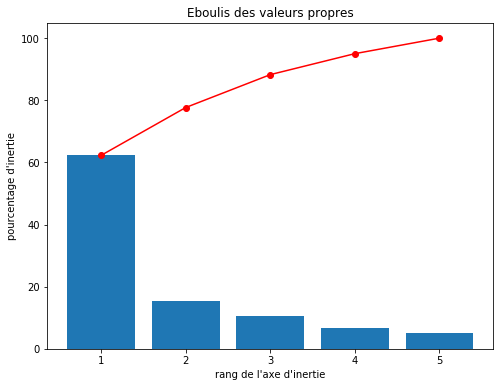

In [30]:
# choix du nombre et des composantes à calculer
n_comp = 5
features = échantillon.columns

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
plt.figure(figsize=(8, 6))
display_scree_plot(pca)

On constaste que plus de 60% de l’inertie totale est associé à F1 et 20% à F2, donc le premier plan factoriel représente 80% de l’inertie totale. Il y a peu de perte d'information.

### 2) Cercle des corrélations <a class="anchor" id="section_3_2"></a>

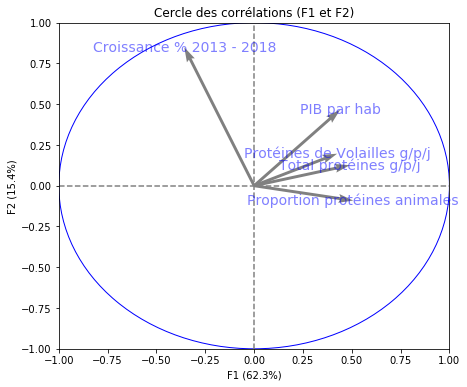

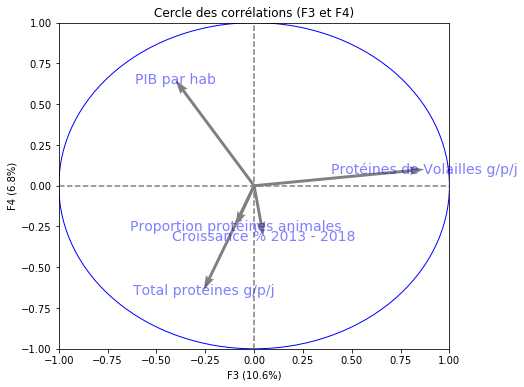

In [31]:
# Cercle des corrélations

pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

Nous pouvons constater que la variable croissance est fortement corrélée à la nouvelle composante F2.  
En effet R(croissance)F2 = 0,80  

Le PIB par habitant à un coeffecient de 0,5 à la fois avec la variable F1 et avec la variable F2.  
Les variables "protéines de volailles", "total des protéines" et "proportion de protéines végétales" sont toutes corrélées à la variable F1 et elles sont donc corrélées entre elles. On y retrouve une certaine logique étant donné qu'elles traitent toutes de la disponibilité en protéines.

### 3) Projections <a class="anchor" id="section_3_3"></a>

#### a. Des individus <a class="anchor" id="section_3_3_1"></a>

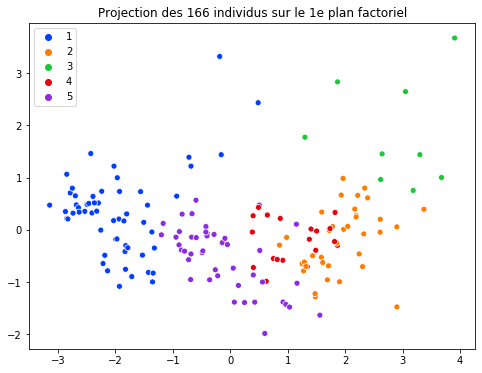

In [32]:
# Affichage du clustering par projection des individus sur le premier plan factoriel

X_projected = pca.transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(X_projected[:, 0], X_projected[:, 1], hue=clusters, cmap = 'jet', palette="bright")
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)


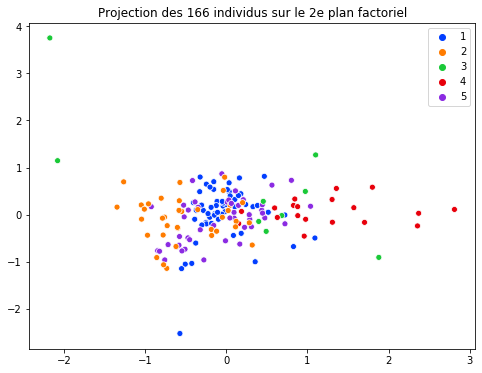

In [33]:
# Affichage du clustering par projection des individus sur le deuxième plan factoriel

plt.figure(figsize=(8, 6))
sns.scatterplot(X_projected[:, 2], X_projected[:, 3], hue=clusters, cmap = 'jet', palette="bright", sizes=10)
plt.title("Projection des {} individus sur le 2e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

#### b. Des centroïdes <a class="anchor" id="section_3_3_2"></a>

In [34]:
# Calcul des coordonnées des centroïdes 
centroidefin = ward.groupby(["cluster"], as_index=False).mean()
centroidefin.to_csv("centroides.csv", index = False)

# Extraction des clutsers
clusters_c = centroidefin["cluster"]
clusters_c = clusters_c.to_numpy()

# Affichage des données des centroïdes
centroidefin = centroidefin.drop(columns=["cluster"])
centroidefin

,Croissance % 2013 - 2018,Proportion protéines animales,Total protéines g/p/j,Protéines de Volailles g/p/j,PIB par hab
0,12.865119,0.305063,63.170714,2.484464,5003.573214
1,1.607241,0.742009,104.151944,8.967778,38288.127778
2,8.789725,0.706566,108.241111,17.344444,70894.877778
3,3.963118,0.638715,83.032105,15.457368,17634.431579
4,4.873581,0.546362,79.687826,5.472174,12226.186957


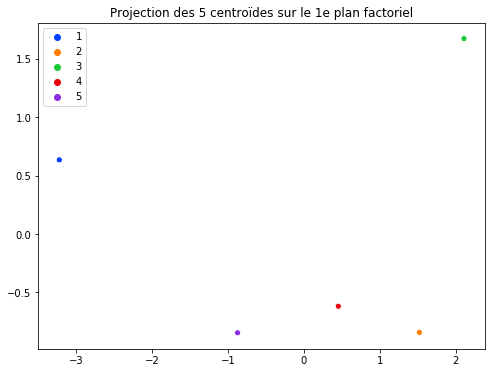

In [35]:
# préparation des données pour le clustering
Xc = centroidefin.values

# Centrage et Réduction
std_scale_c = preprocessing.StandardScaler().fit(Xc)
Xc_scaled = std_scale_c.transform(Xc)

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca_c = decomposition.PCA(n_components=5).fit(Xc)

Xc_projected = pca.transform(Xc_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(Xc_projected[:, 0], Xc_projected[:, 1], hue = clusters_c, cmap = 'jet', palette="bright")
plt.title("Projection des {} centroïdes sur le 1e plan factoriel".format(Xc_projected.shape[0]))
plt.show(block=False)

## IV. Tests <a class="anchor" id="section_4"></a>

### 1) Tests d'adéquation <a class="anchor" id="section_4_1"></a>

In [36]:
ks_2samp(échantillon["Croissance % 2013 - 2018"],list(np.random.normal(np.mean(échantillon["Croissance % 2013 - 2018"]), np.std(échantillon["Croissance % 2013 - 2018"]), 1000)))


Ks_2sampResult(statistic=0.07791566265060242, pvalue=0.33347037467686846)

pvalue > 0,05 -> 5% -> On ne peut donc pas rejeter l’hypothèse de normalité au niveau de test 5%

In [37]:
ks_2samp(échantillon["Proportion protéines animales"],list(np.random.normal(np.mean(échantillon["Proportion protéines animales"]), np.std(échantillon["Proportion protéines animales"]), 1000)))

Ks_2sampResult(statistic=0.09701204819277108, pvalue=0.1273977404570391)

pvalue > 0,05 -> 5% -> On ne peut donc pas rejeter l’hypothèse de normalité au niveau de test 5%

In [38]:
ks_2samp(échantillon["Total protéines g/p/j"],list(np.random.normal(np.mean(échantillon["Total protéines g/p/j"]), np.std(échantillon["Total protéines g/p/j"]), 1000)))


Ks_2sampResult(statistic=0.0772289156626506, pvalue=0.34375557113398336)

pvalue > 0,05 -> 5% -> On ne peut donc pas rejeter l’hypothèse de normalité au niveau de test 5%

In [39]:
ks_2samp(échantillon["Protéines de Volailles g/p/j"],list(np.random.normal(np.mean(échantillon["Protéines de Volailles g/p/j"]), np.std(échantillon["Protéines de Volailles g/p/j"]), 1000)))


Ks_2sampResult(statistic=0.131, pvalue=0.013555163345227772)

pvalue < 0,05 -> 5% -> On peut donc rejeter l’hypothèse de normalité au niveau de test 5%

In [40]:
ks_2samp(échantillon["PIB par hab"],list(np.random.normal(np.mean(échantillon["PIB par hab"]), np.std(échantillon["PIB par hab"]), 1000)))


Ks_2sampResult(statistic=0.19, pvalue=5.617593820961275e-05)

pvalue > 0,05 -> 5% -> On ne peut donc pas rejeter l’hypothèse de normalité au niveau de test 5%

### 2) Test de comparaison <a class="anchor" id="section_4_2"></a> 

#### a. De la croissance <a class="anchor" id="section_4_2_1"></a>

Nous comparons le cluster choisi 3 avec un cluster qui semble proche, le 2.

In [41]:
croissance3 = ward[ward["cluster"]== 3 ]["Croissance % 2013 - 2018"]
croissance2 = ward[ward["cluster"]== 2 ]["Croissance % 2013 - 2018"]

On teste tout d’abord l’égalité des variances à l’aide de la commande :

In [42]:
scipy.stats.bartlett(croissance3,croissance2)

BartlettResult(statistic=3.6105165148493263, pvalue=0.05741528491900823)

La p-valeur valant 0.057, on ne rejette donc pas l’égalité des variances au niveau de test 5%.

On teste ensuite l’égalité des moyennes à l’aide de la commande :

In [43]:
scipy.stats.ttest_ind(croissance3,croissance2, equal_var=True)

Ttest_indResult(statistic=6.267258431774358, pvalue=1.493292347199371e-07)

On obtient une p-valeur égale à environ 1,49×10−07. On constate donc que l’hypothèse d’égalité des moyennes est (très facilement) rejetée à un niveau de test de 5%.

On rejette donc que la croissance suit la même distribution dans les clusters 3 et 2, on a en effet rejeté l’hypothèse d’égalité des moyennes.


#### b. Proportion protéines animales <a class="anchor" id="section_4_2_2"></a>

In [44]:
proportion3 = ward[ward["cluster"]== 3 ]["Proportion protéines animales"]
proportion2 = ward[ward["cluster"]== 2 ]["Proportion protéines animales"]

In [45]:
#Egalité des variances
scipy.stats.bartlett(proportion3,proportion2)

BartlettResult(statistic=0.34294173020798224, pvalue=0.5581361013002559)

La p-valeur valant 0.558, on ne rejette donc pas l’égalité des variances au niveau de test 5%.  

In [46]:
#Egalité des moyennes
scipy.stats.ttest_ind(proportion3,proportion2, equal_var=True)

Ttest_indResult(statistic=-0.945772970614919, pvalue=0.34954895513037454)

La p-valeur valant 0.34, on ne rejette donc pas l’égalité des moyennes au niveau de test 5%.  
On ne peut donc pas globalement rejeter l'hypothèse d'égalité de proportion de protéines animales au niveau de ces clusters.

#### c. Total protéines g/p/j <a class="anchor" id="section_4_2_3"></a>

In [47]:
prot3 = ward[ward["cluster"]== 3 ]["Total protéines g/p/j"]
prot2 = ward[ward["cluster"]== 2 ]["Total protéines g/p/j"]

In [48]:
#Egalité des variances
scipy.stats.bartlett(prot3,prot2)

BartlettResult(statistic=1.1350492803154317, pvalue=0.2867008752903162)

La p-valeur valant 0.28, on ne rejette donc pas l’égalité des variances au niveau de test 5%.  

In [49]:
#Egalité des moyennes
scipy.stats.ttest_ind(prot3,prot2, equal_var=True)

Ttest_indResult(statistic=0.9831511246812381, pvalue=0.331032775616509)

La p-valeur valant 0.331, on ne rejette donc pas l’égalité des variances au niveau de test 5%.  
On ne peut donc pas globalement rejeter l'hypothèse d'égalité des protéines au niveau de ces clusters.

#### d. PIB par hab <a class="anchor" id="section_4_2_4"></a>

In [50]:
PIB3 = ward[ward["cluster"]== 3 ]["PIB par hab"]
PIB2 = ward[ward["cluster"]== 2 ]["PIB par hab"]

In [51]:
#Egalité des variances
scipy.stats.bartlett(PIB3,PIB2)

BartlettResult(statistic=20.124365149622193, pvalue=7.256632321252421e-06)

La p-valeur valant 7,25 on ne rejette donc pas l’égalité des variances au niveau de test 5%.  

In [52]:
#Egalité des moyennes
scipy.stats.ttest_ind(PIB3,PIB2, equal_var=True)

Ttest_indResult(statistic=4.196519221706864, pvalue=0.00013326810185571646)

La p-valeur valant 0.0001, l’hypothèse d’égalité des moyennes est rejetée à un niveau de test de 5%.  
On rejette donc que le PIB par habitant suit la même distribution dans les clusters 3 et 2, on a en effet rejeté l’hypothèse d’égalité des moyennes.

Hypothèses d'égalités acceptées :  
- Protéines animales  
- Total protéines  


Hypothèses d'égalités rejetées :  
- PIB par habitant 
- Croissance

Variable ne suivant pas la loi normale :  
- Protéines de Volailles g/p/j

Nous pouvons conclure que nous avons fait le bon choix au niveau des clusters, le découpage n'a pas été fait artificiellement, les clusters sont bien distincts malgé le fait qu'ils soient les plus similaires.